In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection
from scipy.signal import butter,filtfilt
#import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import h5py
from random import gauss
import math
import multiprocessing
import time
import gc
from itertools import chain

In [5]:
n=8
gestures = ['abduct_p1', 'adduct_p1', 'extend_p1', 'grip_p1', 'pronate_p1', 'rest_p1', 'supinate_p1', 'tripod_p1', 'wextend_p1', 'wflex_p1']

file = h5py.File('./Jehan_Dataset/p00' + str(n) +'/data_allchannels_recalibration.h5', 'r')
print(np.array(file[gestures[0]]).shape)

file = h5py.File('./Jehan_Dataset/p00' + str(n) +'/data_allchannels_initial.h5', 'r')
print(np.array(file[gestures[0]]).shape)

(5, 64, 8000)
(9, 64, 8000)


In [2]:
# 0 for no LOSO; participants here are 1-13
leaveOut = 2

# root mean square instances per channel per image
numRMS = 250 # must be a factor of 1000

# gaussian Noise signal-to-noise ratio
SNR = 15

# magnitude warping std
std = 0.2

wLen = 250 #ms
stepLen = 50 #ms
freq = 4000 #Hz



# Data Extraction

def filter (emg):
    b, a = butter(N=1, Wn=120.0, btype='highpass', analog=False, fs=freq)
    # what axis should the filter apply to? other datasets have axis=0
    return torch.from_numpy(np.flip(filtfilt(b, a, emg),axis=-1).copy())

# returns array with dimensions (# of samples)x64x10x100
def getData(n, gesture):    
    if (n<10):
        file = h5py.File('./Jehan_Dataset/p00' + str(n) +'/data_allchannels_initial.h5', 'r')
    else:
        file = h5py.File('./Jehan_Dataset/p0' + str(n) +'/data_allchannels_initial.h5', 'r')
    data = filter(torch.from_numpy(np.array(file[gesture])).unfold(dimension=-1, size=int(wLen/1000*freq), step=int(stepLen/1000*freq))).unfold(dimension=-1, 
                    size=int(wLen/(1000*numRMS)*freq), step=int(wLen/(1000*numRMS)*freq))
    
    return torch.cat([data[i] for i in range(len(data))], axis=1).permute([1, 0, 2, 3])

gestures = ['abduct_p1', 'adduct_p1', 'extend_p1', 'grip_p1', 'pronate_p1', 'rest_p1', 'supinate_p1', 'tripod_p1', 'wextend_p1', 'wflex_p1']
def getEMG(n):
    return torch.cat([torch.sqrt(torch.mean(getData(n, name) ** 2, dim=3)) for name in gestures], axis=0)

def getGestures(n):
    if (n<10):
        file = h5py.File('./Jehan_Dataset/p00' + str(n) +'/data_allchannels_initial.h5', 'r')
    else:
        file = h5py.File('./Jehan_Dataset/p0' + str(n) +'/data_allchannels_initial.h5', 'r')
    
    numGestures = []
    for gesture in gestures:
        data = filter(torch.from_numpy(np.array(file[gesture])).unfold(dimension=-1, size=int(wLen/1000*freq), step=int(stepLen/1000*freq))).unfold(dimension=-1, 
        size=int(wLen/(1000*numRMS)*freq), step=int(wLen/(1000*numRMS)*freq))
        numGestures += [len(data)]
    return numGestures



# Data Augmentation

# gaussian noise
def addNoise (emg):
    for i in range(len(emg)):
        emg[i] += gauss(0.0, math.sqrt((emg[i] ** 2) / SNR))
    return emg

data_noRMS = []
currParticipant = 8

# magnitude warping
def magWarp (n):
    global data_noRM
    global currParticipant
    global data_noRMS

    if (len(data_noRMS) == 0):
        data_noRMS = torch.cat([getData(currParticipant, name) for name in gestures], axis=0)
    emg = data_noRMS[n].view(64, wLen*4)

    cs = scipy.interpolate.CubicSpline([i*100 for i in range(11)], [gauss(1.0, std) for i in range(11)])
    scaleFact = cs([i for i in range(wLen*4)])
    for i in range(len(scaleFact)):
        emg[:, i] = emg[:, i] * scaleFact[i]

    return torch.sqrt(torch.mean(emg.unfold(dimension=-1, size=int(wLen/(1000*numRMS)*freq), step=int(wLen/(1000*numRMS)*freq)) ** 2, dim=2)).view([64*numRMS])

# electrode offseting
def shift_up (batch):
    batch_up = batch.view(4, 16, numRMS).clone()
    for k in range(len(batch_up)):
        for j in range(len(batch_up[k])-1):
            batch_up[k][j] = batch_up[k][j+1]                   
    return batch_up

def shift_down (batch):
    batch_down = batch.view(4, 16, numRMS).clone()
    for k in range(len(batch_down)):
        for j in range(len(batch_down[k])-1):
            batch_down[k][len(batch_down[k])-j-1] = batch_down[k][len(batch_down[k])-j-2]
    return batch_down



# raw emg data -> 64x(numRMS) image

cmap = mpl.colormaps['viridis']
order = list(chain.from_iterable([[[k for k in range(64)][(i+j*16+32) % 64] for j in range(4)] for i in range(16)]))
def dataToImage (emg):
    rectified = emg - min(emg)
    rectified = rectified / max(rectified)

    data = rectified.view(64, numRMS).clone()
    data = torch.stack([data[i] for i in order])

    frames = []
    for i in range(numRMS):
        frames += [np.transpose(np.array(list(map(lambda x: cmap(x[i]), data.numpy()))), axes=[1, 0])[:3]]

    image_1 = torch.from_numpy(np.transpose(np.stack(frames[:(int(len(frames)/4))]), axes=[1, 2, 0]))
    image_2 = torch.from_numpy(np.transpose(np.stack(frames[(int(len(frames)/4)):int(len(frames)/2)]), axes=[1, 2, 0]))
    image_3 = torch.from_numpy(np.transpose(np.stack(frames[(int(len(frames)/2)):int(len(frames)*3/4)]), axes=[1, 2, 0]))
    image_4 = torch.from_numpy(np.transpose(np.stack(frames[(int(len(frames)*3/4)):]), axes=[1, 2, 0]))
    
    image_1 = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_1)
    image_2 = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_2)
    image_3 = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_3)
    image_4 = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_4)


    return torch.cat([image_1, image_2, image_3, image_4], dim=2).numpy().astype(np.float32)
    '''
    image = torch.from_numpy(np.transpose(np.stack(frames), axes=[1, 2, 0]))
    return transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image).numpy().astype(np.float32)
    '''



# image generation with aumgentation
dataCopies = 1

def oneWindowImages(emg):
    combinedImages = []

    combinedImages.append(dataToImage(emg))
    #allImages.append(dataToImage(shift_up(batch)))
    #allImages.append(dataToImage(shift_down(batch)))
    #for j in range(1):
        #combinedImages.append(dataToImage(addNoise(emg)))
        #combinedImages.append(dataToImage(magWarp(i)))
    
    return combinedImages

curr = 0
def getImages (emg):
    global curr
    curr += 1
    print(curr)

    allImages = []
    pool = multiprocessing.Pool()
    allImages_async = pool.map_async(oneWindowImages, [(emg[i]) for i in range(len(emg))])
    allImages = list(chain.from_iterable(allImages_async.get()))

    '''
    if i % 1000 == 0:
        print("progress: " + str(i) + "/" + str(len(emg)))
        #print(labels[i])
        plt.imshow(allImages[i*dataCopies].T, origin='lower')
        plt.axis('off')
        plt.show()
    ''' 
    return allImages



# no augmentation image generation

def getImages_noAugment (emg):
    allImages = []
    pool = multiprocessing.Pool()
    allImages_async = pool.map_async(dataToImage, [(emg[i]) for i in range(len(emg))])
    allImages = allImages_async.get()
    return allImages



# extracting raw EMG data

participants = [8,9,11,12,13,15,16,17,18,19,20,21,22]
pool = multiprocessing.Pool(processes=13)
emg_async = pool.map_async(getEMG, participants)
emg = emg_async.get()
print("EMG data extracted")



# generating labels

numGestures_async = pool.map_async(getGestures, participants)
numGestures = numGestures_async.get()

labels = []
windowsPerSample = 36 # change this if wLen or stepLen is changed

for nums in numGestures:
    sub_labels = torch.tensor(()).new_zeros(size=(sum(nums)*windowsPerSample, 10))
    subGestures = [(i * windowsPerSample) for i in nums]
    index = 0
    count = 0

    for i in range(len(sub_labels)):
        sub_labels[i][index] = 1.0
        count += 1
        if (count >= subGestures[index]):
            index += 1
            count = 0
    
    labels += [sub_labels]
labels = list(labels)
print("labels generated")



# LOSO-CV data processing

if leaveOut != 0:
    emg_out = emg.pop(leaveOut-1)
    emg_in = np.concatenate([np.array(i.view(len(i), 64*numRMS)) for i in emg], axis=0, dtype=np.float16)
    
    s = preprocessing.StandardScaler().fit(emg_in)
    emg_out = torch.from_numpy(s.transform(np.array(emg_out.view(len(emg_out), 64*numRMS))))
    del emg_in
    
    X_validation = torch.tensor(np.array(getImages_noAugment(emg_out))).to(torch.float16)
    Y_validation = torch.from_numpy(np.array((labels.pop(leaveOut-1)))).to(torch.float16)
    del participants[leaveOut-1]
    del emg_out

    print("validation images generated")

    '''
    data = []
    for i in range(len(emg)):
        print(i)
        data_noRMS = []
        currParticipant = participants[i]
        data += [getImages(torch.from_numpy(s.transform(np.array(emg[i].view(len(emg[i]), 64*numRMS)))))]
        #data += [getImages_noAugment(torch.from_numpy(s.transform(np.array(emg[i]))))]
    '''
    X_train = torch.from_numpy(np.concatenate([np.array(getImages(torch.from_numpy(s.transform(np.array(emg[i].view(len(emg[i]), 64*numRMS)))))).astype(np.float16) for i in range(len(emg))], axis=0, dtype=np.float16)).to(torch.float16)
    Y_train = torch.from_numpy(np.concatenate([np.repeat(np.array(i), dataCopies, axis=0) for i in labels], axis=0, dtype=np.float16)).to(torch.float16)

    '''
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(np.concatenate([np.array(getImages(torch.from_numpy(s.transform(np.array(emg[i].view(len(emg[i]), 64*numRMS)))))).astype(np.float16) for i in range(len(emg))], axis=0, dtype=np.float16),
                                                                                    np.concatenate([np.repeat(np.array(i), dataCopies, axis=0) for i in labels], axis=0, dtype=np.float16), test_size=0.1)
    '''

# non-LOSO data processing (not updated)

else:
    data = []
    for i in range(len(emg)):
        data += [getImages(emg[i])]

    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(np.concatenate([np.array(i) for i in data], axis=0, dtype=np.float16),
                                                                                    np.concatenate([np.repeat(np.array(i), dataCopies, axis=0) for i in labels], axis=0, dtype=np.float16), test_size=0.2)
    X_validation, X_test, Y_validation, Y_test = model_selection.train_test_split(X_validation, Y_validation, test_size=0.5)
    X_train = torch.from_numpy(X_train).to(torch.float16)
    Y_train = torch.from_numpy(Y_train).to(torch.float16)
    X_validation = torch.from_numpy(X_validation).to(torch.float16)
    Y_validation = torch.from_numpy(Y_validation).to(torch.float16)
    X_test = torch.from_numpy(X_test).to(torch.float16)
    Y_test = torch.from_numpy(Y_test).to(torch.float16)

print(X_train.size())
print(Y_train.size())
print(X_validation.size())
print(Y_validation.size())

EMG data extracted
labels generated
validation images generated
1
2
3
4
5
6
7
8
9
10
11
12
torch.Size([42516, 3, 64, 250])
torch.Size([42516, 10])
torch.Size([3600, 3, 64, 250])
torch.Size([3600, 10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=torch.float16)


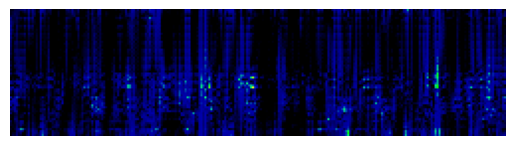

In [62]:
pos = 3350
print(Y_validation[pos])
plt.imshow(np.transpose(np.array(X_validation[pos]).astype(np.float32), [1, 2, 0]), origin='lower')
plt.axis('off')
plt.show()

In [5]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
#model = nn.Sequential(*list(model.children())[:-2])
model = nn.Sequential(*list(model.children())[:-4])
num_features = model[-1][-1].conv3.out_channels
#num_features = model.fc.in_features
dropout = 0.5

num = 0
for name, param in model.named_parameters():
    num += 1
    #if (num > 159): # for freezing layers 1, 2, 3, and 4
    #if (num > 129): # for freezing layers 1, 2, and 3
    #if (num > 72): # for freezing layers 1 and 2
    #if (num > 33): #for freezing layer 1
    if (num >= 0): # for no freezing
        param.requires_grad = True
    else:
        param.requires_grad = False

model.add_module('avgpool', nn.AdaptiveAvgPool2d(1))
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(num_features, 512))
model.add_module('relu', nn.ReLU())
model.add_module('dropout1', nn.Dropout(dropout))
#model.add_module('fc2', nn.Linear(512, 512))
#model.add_module('relu2', nn.ReLU())
#model.add_module('dropout2', nn.Dropout(dropout))
model.add_module('fc3', nn.Linear(512, 10))
#model.add_module('fc1', nn.Linear(num_features, 10))
model.add_module('softmax', nn.Softmax(dim=1))

'''
layers = [(name, param.requires_grad) for name, param in model.named_parameters()]
for i in range(len(layers)):
    print(layers[i])
'''

class Data(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

batch_size = 64
train_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(X_validation, Y_validation)), batch_size=batch_size)
if (leaveOut == 0):
    test_loader = DataLoader(list(zip(X_test, Y_test)), batch_size=batch_size)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
learn = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learn)

In [6]:
# Training loop
gc.collect()
torch.cuda.empty_cache()

#run = wandb.init(name='CNN', project='emg_benchmarking', entity='msoh')
#wandb.config.lr = learn

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

#wandb.watch(model)

for epoch in range(num_epochs):
    model.train()
    train_acc = 0.0
    train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device).to(torch.float32)
        Y_batch = Y_batch.to(device).to(torch.float32)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        train_loss += loss.item()

        train_acc += np.mean(np.argmax(output.cpu().detach().numpy(), 
                                       axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device).to(torch.float32)
            Y_batch = Y_batch.to(device).to(torch.float32)

            output = model(X_batch)
            val_loss += criterion(output, Y_batch).item()

            val_acc += np.mean(np.argmax(output.cpu().detach().numpy(), axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f}")

    '''
    wandb.log({
        "Epoch": epoch,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
    '''
#run.finish()

if (leaveOut == 0):
    # Testing
    pred = []
    true = []

    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device).to(torch.float32)
            Y_batch = Y_batch.to(device).to(torch.float32)

            output = model(X_batch)
            test_loss += criterion(output, Y_batch).item()

            test_acc += np.mean(np.argmax(output.cpu().detach().numpy(), axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

            output = np.argmax(output.cpu().detach().numpy(), axis=1)
            pred.extend(output)
            labels = np.argmax(Y_batch.cpu().detach().numpy(), axis=1)
            true.extend(labels)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

    cf_matrix = confusion_matrix(true, pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = np.arange(1, 11, 1),
                        columns = np.arange(1, 11, 1))
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True, fmt=".3f")
    plt.savefig('output.png')

cuda
Epoch 1/50 | Train Loss: 1.7124 | Val Loss: 1.5767
Train Accuracy: 0.7753 | Val Accuracy: 0.8986
Epoch 2/50 | Train Loss: 1.4855 | Val Loss: 1.5610
Train Accuracy: 0.9822 | Val Accuracy: 0.9065
Epoch 3/50 | Train Loss: 1.4729 | Val Loss: 1.5286
Train Accuracy: 0.9915 | Val Accuracy: 0.9380
Epoch 4/50 | Train Loss: 1.4683 | Val Loss: 1.5445
Train Accuracy: 0.9949 | Val Accuracy: 0.9230
Epoch 5/50 | Train Loss: 1.4667 | Val Loss: 1.5577
Train Accuracy: 0.9957 | Val Accuracy: 0.9076
Epoch 6/50 | Train Loss: 1.4657 | Val Loss: 1.5510
Train Accuracy: 0.9964 | Val Accuracy: 0.9123
Epoch 7/50 | Train Loss: 1.4658 | Val Loss: 1.5508
Train Accuracy: 0.9963 | Val Accuracy: 0.9117
Epoch 8/50 | Train Loss: 1.4653 | Val Loss: 1.5433
Train Accuracy: 0.9964 | Val Accuracy: 0.9194
Epoch 9/50 | Train Loss: 1.4651 | Val Loss: 1.5552
Train Accuracy: 0.9966 | Val Accuracy: 0.9057
Epoch 10/50 | Train Loss: 1.4654 | Val Loss: 1.5719
Train Accuracy: 0.9965 | Val Accuracy: 0.8893
Epoch 11/50 | Train Loss

KeyboardInterrupt: 